In [1]:
import os
import pathlib

import numpy as np
import pandas as pd

import shapely.geometry
import rasterio
import rasterio.plot
import rasterio.mask
import rasterio.features
import geopandas as gpd
import matplotlib.pyplot as plt

from util_data_exploration import get_tile_images, reconvert_np_to_rasterio_dataset

## Contents of notebook
- collecting all relevant scenario folders for processing
- processing terrain maps, flood maps, and Rotterdam district areas

This notebook specifically processes flood scenario data from LIWO, filters it with the terrain (DSM) data from AHN, and separates the flood data per district (wijk) in Rotterdam.

## Usage notes
- LIWO flood data should be placed in the data/flood_breaks directory, as separate directories per scenario. This script should automatically detect the scenarios.
- The AHN terrain data (Digital Surface Mapping) data file is pre-processed and present in data/rdam_topo_bool_map.tif . The original raw data from AHN consists of multiple tiles and needed to be combined together, which was done in a different script (TODO: explain that script)
- the Rotterdam district vector data is pre-processed and present in data/wijk_geometries.shp. Note that this script takes only a subset of the data, since industry-only districts and the port district of R'dam is omitted. Note that the district labels across different datasets can be different (some explicitly list all the industry districts, others just lump the industry districts as a generic 'bedrijventerrein' catch-all category)

In [2]:
# Search for flood scenario directories in data/flood_breaks
base_path = '../data/flood_breaks'

# find valid folders
target_ending = '.tif'  # look for tiff files only
scenario_paths = []  # directory paths to the scenario files
scenario_names = []  # names of the scenarios
for path in os.listdir(f'{base_path}'):
    if '.zip' not in path:  ## exclude zip files, look for folders
        for item in os.listdir(f'{base_path}/{path}'):
            if target_ending in item:  # if tiff file
                scenario_paths.append(f'{base_path}/{path}/{item}')  # save relative path
                scenario_names.append(path.lower())  # the scenario names are on the directory, not the tif file itself.

In [13]:
# extract and filter Rotterdam district VECTOR data for filtering later on
wijken = gpd.read_file('../data_model_inputs/rdam_districts/rdam_districts_city_only.shp').set_index('index')

In [4]:
# save the filtered wijks into a new file

## Process Rotterdam terrain data for filtering
The following block processes the terrain data from AHN. The pre-processed data is a rasterio dataset object containing 0 for water and 1 for land, and will be used to filter out inland bodies of water in the flood dataset (some water bodies are marked as flooded, even though there won't be any buildings on them).

The procedure uses a hacky method based on <https://gis.stackexchange.com/questions/363183/crop-two-rasters-to-common-extent-where-pixelvalues-are-not-nodata>, converting the terrain (raster) to vector to be used as a mask for the flood map.

In [5]:
# Read rotterdam land bool map, generated from map_explore.ipynb
terrain_bool_ds = rasterio.open('../data/rdam_topo_bool_map.tif')
terrain_bool_map = terrain_bool_ds.read(1)
# in the map 0 = water, 1 = land
# convert terrain map (raster) to vector map for masking.

knockout_meta = terrain_bool_ds  # with metadata
knockout = terrain_bool_map
geoms_water = []
geoms_land = []

# convert the raster to vector features, for masking out inland water bodies later on
for geometry, raster_value in rasterio.features.shapes(knockout, transform=knockout_meta.transform):
    if raster_value == 0:  # 0 = water, 1 = land
        geoms_water.append(geometry)
    else:
        geoms_land.append(geometry)


## Processing flood data, with filtering/masking from the terrain map and district boundaries.
This section processes the flood data with the terrain maps (to ignore inland water) and district geometry. The flood data will be separated according to the districts, and saved into a pandas dataframe (currently 'data_model_inputs/flood_scenarios_v2.pickletable') for further usage. An entry in the dataframe includes the distribution of land 'tiles'.



In [18]:
# use generated vectors as mask. Should be less sensitive to differential spatial resolution than older method in map_explore.ipynb

# TODO: list out assumptions in this datacleaning

temp_dict = {}  # for temporary storage, for generation of pandas dataframe
flooded_pct_threshold_district = .01  # percentage of flooded landmass to be considered significant (1%)
flooded_thres_tile = 0.01
force_equalise = True  # bool argument to force non-data (but still landmass) to 0 (TODO: explain)
eliminate_shallow = True
resolutions = {}  # to note the resolution levels per map

for idx, path in enumerate(scenario_paths):
    with rasterio.open(path) as input_flood_ds:  # open the flood scenario in 'safe' manner
        input_flood_scenario = scenario_names[idx]  # get scenario name
        map_res = input_flood_ds.res[0]  # resolution of map in meters
        resolutions[input_flood_scenario] = map_res

        # first mask out inland water bodies to minimise invalid flood values
        out_flood_img, out_transform = rasterio.mask.mask(dataset=input_flood_ds,
                                                          shapes=geoms_land,
                                                          crop=True,
                                                          nodata=np.nan,
                                                          pad=True)
        # use the first band (count=1) for further cropping, it contains all flood data. Other bands contain bins of flood depths
        out_flood_ds = reconvert_np_to_rasterio_dataset(raster=out_flood_img[0, :, :],
                                                        transform=out_transform,
                                                        count=1)  # only use the 1st band

        # cut out the flood submaps with the R'dam district shapes
        # filter out districts that are not affected
        # caveat: dependent on which wijken are collected for this study (eg. the business-specific areas are not included)
        for wijk in wijken.index:  # numeric index
            geo = wijken.geometry[wijk]

            # cut out flood values belonging to the specific wijk
            try:
                submap, transform = rasterio.mask.mask(dataset=out_flood_ds,
                                                       shapes=[geo],
                                                       crop=True,
                                                       nodata=np.nan)
                # eliminate shallow water levels (default 1cm)
                if eliminate_shallow:
                    submap = np.where(np.logical_and(submap < flooded_thres_tile, submap > 0.), 0., submap)
                # process to see if map contains any valid flood values
                submap_depths = submap[submap > 0.]  # 1d array of parcels higher than 0
                if submap_depths.size > 0:  # if there are areas higher than 0

                    # if non-data exists on the cropped submap, force them to 0. (A)
                    if force_equalise:
                        submap = np.where(submap < 0., 0., submap)

                    # gets the distribution of land parcels. Used for sampling buildable land
                    flatten = submap[submap >= 0.]
                    if submap_depths.size / flatten.size >= flooded_pct_threshold_district:  # if flooded proportion is higher than threshold

                        # save to dict for DataFrame generation
                        temp_dict[f'{input_flood_scenario},{wijk}'] = {'scenario': input_flood_scenario,
                                                                       'wijk': wijk,
                                                                       'submap': submap,
                                                                       'transform': transform,
                                                                       'flatten': flatten,
                                                                       'resolution': map_res}

            except ValueError:  # occurs if the map geometry doesn't overlap flood area
                pass  # no appending to flood_submaps
                # flood_submaps[name] = None # could also ignore

In [19]:
if temp_dict:  # if dict is not empty
    flood_submaps_df = pd.DataFrame.from_dict(temp_dict, orient='index').astype(
        {'scenario': 'category',
         'wijk': 'category'})
    flood_submaps_df['scale'] = (flood_submaps_df.resolution.max() / flood_submaps_df.resolution).round().astype(int)

    # note: + 0.1 because pandas round does not round up 0.1
    round_addon = 0.1
    flood_submaps_df['flatten_size'] = [v.size / flood_submaps_df.loc[idx, 'scale'] + round_addon for idx, v in
                                        flood_submaps_df.flatten.iteritems()]
    flood_submaps_df['flood_size'] = [np.count_nonzero(v) / flood_submaps_df.loc[idx, 'scale'] + round_addon for idx, v in
                                      flood_submaps_df.flatten.iteritems()]

    # items for sanity check
    # flood_submaps_df['canvas_size'] = [v.size / flood_submaps_df.loc[idx,'scale'] for idx, v in flood_submaps_df.submap.iteritems()]
    # flood_submaps_df['trunc_test'] = [np.sum(np.logical_and(v < flooded_thres_tile,  v > 0.)) / flood_submaps_df.loc[idx, 'scale'] for idx, v in flood_submaps_df.flatten.iteritems()]

    flood_submaps_df = flood_submaps_df.round({'resolution': 0,
                                               'flatten_size': 0,
                                               'flood_size': 0})\
                                                .astype({
                                                'resolution': int,
                                                'flatten_size': int,
                                                'flood_size': int})
    # clean and truncate floodmaps since the flood-data borders are inconsistent

    # save dataframe to disk (uncomment when necessary)
    flood_submaps_df.to_pickle('../data_model_inputs/flood_scenarios_v2.pickletable')

In [14]:
for n in flood_submaps_df.flatten.iteritems():
    print(n)

('boerengatsluis_1e6,0', array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.0831, 0.0384, 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.4795,
       0.    , 0.    , 0.3607, 0.3187, 0.3187, 0.066 , 0.1631, 0.4054,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.1269, 0.    , 0.044 ,
       0.3839, 0.0934, 0.1825, 0.3323, 0.312 , 0.1871, 0.4629, 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.2863, 0.    , 0.7651,
       0.1226, 0.    , 0.    , 0.2202, 0.4272, 0.4799, 1.0252, 0.    ,
       0.287 , 0.    , 0.    , 0.    , 0.    , 0.   

In [ ]:
del flood_submaps_df

## Experiments with I/O

In [8]:
flood_submaps_df_open = pd.read_pickle('../data_model_inputs/flood_scenarios_v2.pickletable')
# flood_submaps_df_open['size'] = [a.size for a in flood_submaps_df_open['flatten']]
# flood_submaps_df_open['size2'] = [a.size for a in flood_submaps_df_open.submap]

In [9]:
test_scenarios = flood_submaps_df_open.scenario.unique()

In [10]:
subset = flood_submaps_df_open.loc[flood_submaps_df_open['scenario'].isin(test_scenarios)]


In [11]:
# uniques = ['rotterdam-centrum', 'delfshaven']
uniques = subset.wijk.unique()
size_key = 'flatten_size'
for wijk in uniques:
    subsubset = subset.loc[subset['wijk'] == wijk, :]
    if subsubset.ndim > 1:  # more than one entry
        pass
        # check the size attribute
        # view1 = subsubset[size_key] == subsubset[size_key][0]
        # view2 = subsubset[size_key].unique()
        # if (subsubset[size_key] == subsubset[size_key][0]).all():
        #     print(f'goed: {wijk}')
        # else:
        #     print(f"fout: {wijk}")
        #     break

    else:
        print(f'leeg: {wijk}')
    break


In [12]:
# check = flood_submaps_df_open.loc['boerengatsluis_1mil,rotterdam-centrum', 'submap']
# check2 = flood_submaps_df_open.loc['parksluizen_1mil,rotterdam-centrum', 'submap']

KeyError: 'boerengatsluis_1mil,rotterdam-centrum'

In [ ]:
# visual verification of flooded tiles and water level distribution
# flood_submaps_df_open['flooded'] = [(a > 0.).sum() for a in flood_submaps_df_open['submap']]
# flood_submaps_df_open['water_level'] = [(a[a > 0.]).max() for a in flood_submaps_df_open['submap']]

# Plot map

In [25]:

wijken = gpd.read_file('../data_model_inputs/rdam_districts/rdam_districts.shp').set_index('WK_NAAM')
wijken['included'] = False
to_keep = pd.read_pickle('../data_model_inputs/households_brackets_per_wijk.pickletable')
to_drop = ['Hoek van Holland', 'Haven- en industriegebieden', 'Rozenburg', 'Hoogvliet', 'Pernis']
to_keep = to_keep.drop(labels=to_drop)
#
wijken.loc[to_keep.index, 'included'] = True
# to_drop = [n.lower().replace(' ','-') for n in to_drop]
# wijken.loc[to_keep, 'included'] = True

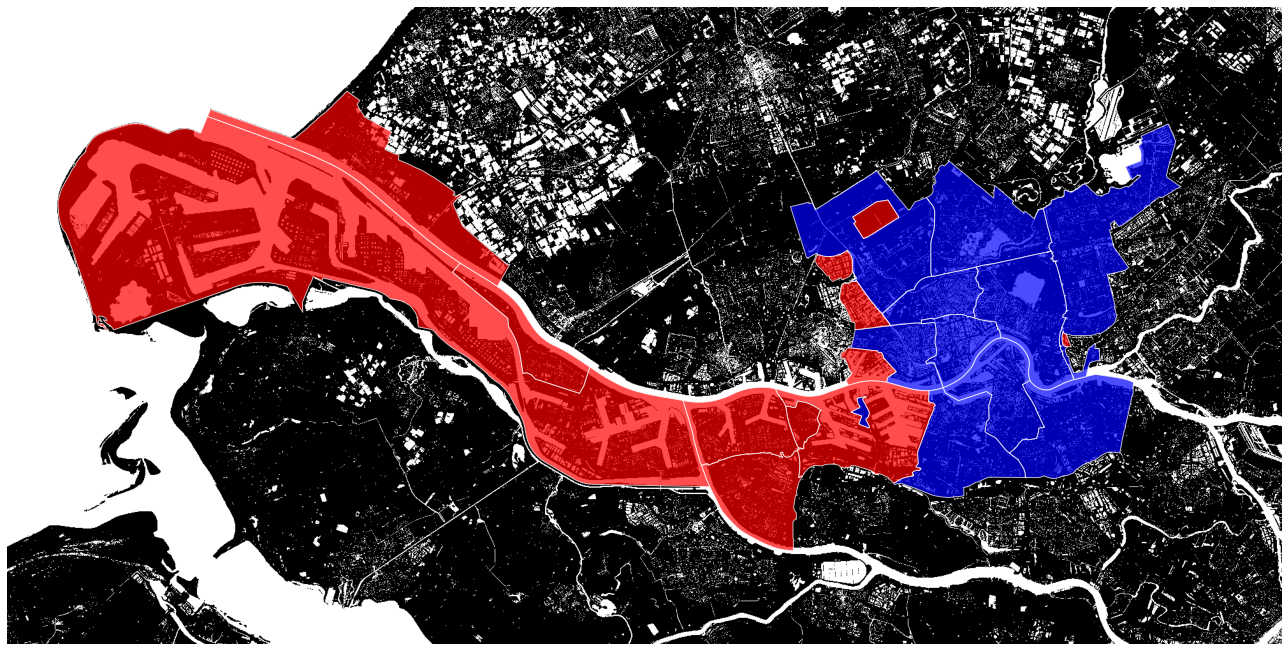

In [26]:
# plotty plot plot
fig, ax = plt.subplots(figsize=(18, 10))
# plt.imshow(view1)
rasterio.plot.show(terrain_bool_ds, ax=ax, cmap='binary')
wijken.plot(ax=ax, column='included', cmap='bwr_r', **{'alpha': 0.7,
                                                       'edgecolor': 'w'})
wijken['centroids'] = wijken['geometry'].centroid
plt.axis('off')
plt.tight_layout()
# fig.savefig('../data/@outputs/rdam_map_and_district_borders_2_nonames.png', dpi=300)
# for idx, row in wijken.iterrows():  # introduce names into the map
#     if " " in idx:
#         idx = idx.replace(" ", '\n')
#     elif "-" in idx:
#         idx = idx.replace('-', '-\n')
#     plt.text(s=idx, x=row['centroids'].x, y=row['centroids'].y, fontsize='x-large', horizontalalignment='center', **{'color': 'yellow'})

# fig.savefig('../data/@outputs/rdam_map_and_district_borders_2.png', dpi=300)